<a href="https://colab.research.google.com/github/BenjaminEngel919/Medical-Data/blob/main/Stroke_Prediction_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Benjamin Engel

##Usual Imports

In [1]:
# Pandas
import pandas as pd
# Numpy
import numpy as np
# MatplotLib
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

# Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Classification Metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, \
f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay


# Set global scikit-learn configuration 
from sklearn import set_config
# Display estimators as a diagram
set_config(display='diagram') # 'text' or 'diagram'}

In [2]:
## Import and mount drive from Google Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Load the data
stroke = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/healthcare-dataset-stroke-data.csv')

In [4]:
stroke.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [5]:
#Object Columns
stroke_types = stroke.dtypes
str_cols = stroke_types[ stroke_types=='object'].index
str_cols

Index(['gender', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status'],
      dtype='object')

In [6]:
## Display the number of rows and columns for the dataframe
stroke.shape
print(f'There are {stroke.shape[0]} rows, and {stroke.shape[1]} columns.')

There are 5110 rows, and 12 columns.


In [7]:
# Display the column names, count of non-null values, and their datatypes
stroke.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


#Cleaning the Data

In [8]:
# Drop columns
#Column id has nothing to do with Strokes, so we will drop it
stroke = stroke.drop(columns=['id'])
stroke = stroke.drop(columns=['ever_married'])

In [9]:
# Display the number of duplicate rows in the dataset
print(f'There are {stroke.duplicated().sum()} duplicate rows.')

There are 0 duplicate rows.


In [10]:
# Display the total number of missing values
print(f'There are {stroke.isna().sum().sum()} missing values.')

There are 201 missing values.


In [11]:
# Check for missing values for each feature.
stroke.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [12]:
bmi_mean = stroke['bmi'].mean()
stroke['bmi'].fillna(bmi_mean,inplace = True)
stroke.isna().sum()
stroke.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   work_type          5110 non-null   object 
 5   Residence_type     5110 non-null   object 
 6   avg_glucose_level  5110 non-null   float64
 7   bmi                5110 non-null   float64
 8   smoking_status     5110 non-null   object 
 9   stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 399.3+ KB


In [13]:
# Check for and address any impossible values in numeric columns.
stroke.describe(include='number')

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.698018,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.800000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.400000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,32.800000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


- Only outlier I see is bmi of 97.6. But sadly this is very possible for the super obese. So I will leave it be.

In [14]:
stroke['work_type'].unique()

array(['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked'],
      dtype=object)

In [15]:
# Fixing Work Type Column discrepancies
stroke['work_type'].replace({"Private":"Job", "Self-employed":"Self", "Govt_job":"Job","children":"No Job", "":"Job"}, inplace = True)
stroke['work_type'].value_counts()

Job             3582
Self             819
No Job           687
Never_worked      22
Name: work_type, dtype: int64

In [16]:
stroke['smoking_status'].unique()

array(['formerly smoked', 'never smoked', 'smokes', 'Unknown'],
      dtype=object)

In [17]:
# Fixing Smoking status Column discrepancies
stroke['smoking_status'].replace({"formeryly smoked":"Smokes", "never smoked":"NonSmoking", "smokes":"Smokes","Unknown":"Smokes"}, inplace = True)
stroke['smoking_status'].value_counts()

Smokes             2333
NonSmoking         1892
formerly smoked     885
Name: smoking_status, dtype: int64

In [18]:
# Check for and address any inconsistent values in categorical columns.
stroke.describe(include='object')

,gender,work_type,Residence_type,smoking_status
count,5110,5110,5110,5110
unique,3,4,2,3
top,Female,Job,Urban,Smokes
freq,2994,3582,2596,2333


In [19]:
#Object Type Columns
dtypes = stroke.dtypes
str_cols = dtypes[dtypes=='object'].index
str_cols

Index(['gender', 'work_type', 'Residence_type', 'smoking_status'], dtype='object')

In [20]:
for col in str_cols:
    print(f"- Column= {col}")
    print(stroke[col].value_counts(dropna=False))
    print('\n\n')

- Column= gender
Female    2994
Male      2115
Other        1
Name: gender, dtype: int64



- Column= work_type
Job             3582
Self             819
No Job           687
Never_worked      22
Name: work_type, dtype: int64



- Column= Residence_type
Urban    2596
Rural    2514
Name: Residence_type, dtype: int64



- Column= smoking_status
Smokes             2333
NonSmoking         1892
formerly smoked     885
Name: smoking_status, dtype: int64





Going to drop Unknown in Gender and Never Worked in work type. This way it won't be treated as noise in the Dataset later.


In [21]:
stroke[stroke['gender']=='Other']

,gender,age,hypertension,heart_disease,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
3116,Other,26.0,0,0,Job,Rural,143.33,22.4,formerly smoked,0


In [22]:
stroke.drop(axis=0, index=3116, inplace=True)

In [23]:
stroke['work_type'] = stroke['work_type'].replace('Never_worked', 'No Job',regex=True)

#Visuals

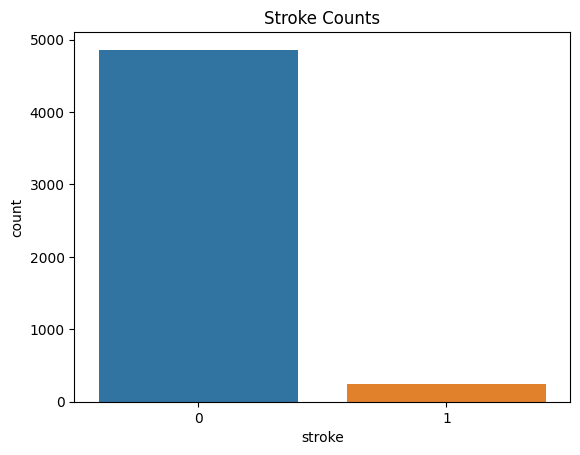

In [24]:
# Check univariate distributions and explore categorical variable(s)
import seaborn as sns
ax = sns.countplot(x=stroke['stroke'])
ax.set_title('Stroke Counts');

Highly Unbalanced data set. In a good way.

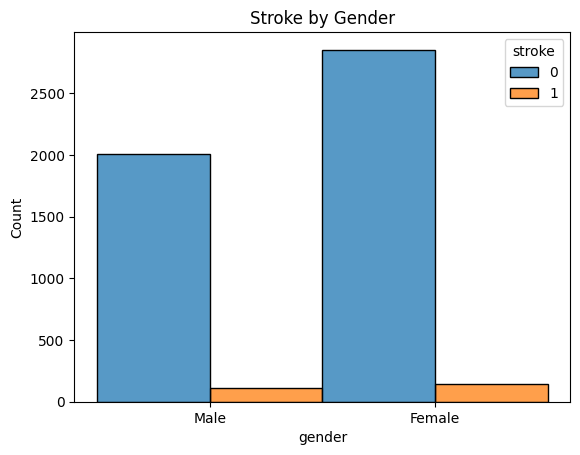

In [25]:
sns.histplot(binwidth=1,
            hue=stroke['stroke'],
            x=stroke['gender'],
            data=stroke,
            stat="count",
            multiple="dodge").set(title='Stroke by Gender');

Suprisingly more total strokes in females but higher percentage of males have them.

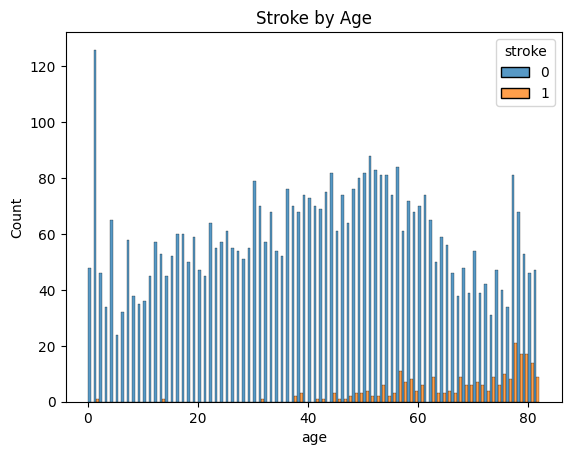

In [26]:
sns.histplot(binwidth=1,
            hue=stroke['stroke'],
            x=stroke['age'],
            data=stroke,
            stat="count",
            multiple="dodge").set(title='Stroke by Age');

This graph shows how rare strokes are in your 30s and 40s and how the occurance increases as you age.

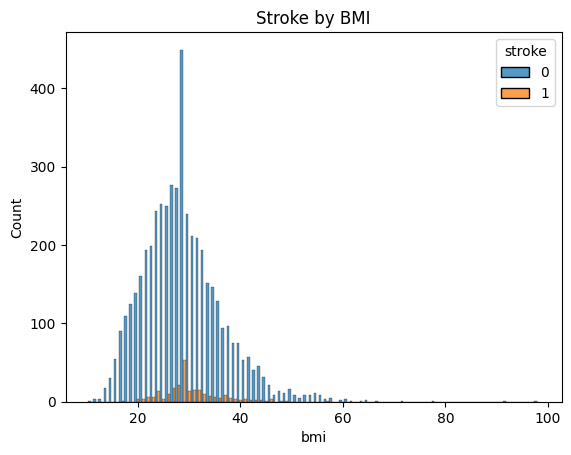

In [27]:
sns.histplot(binwidth=1,
            hue=stroke['stroke'],
            x=stroke['bmi'],
            data=stroke,
            stat="count",
            multiple="dodge").set(title='Stroke by BMI');

This graph shows as your bmi gets into the obese catagory your stroke risk goes up greatly.

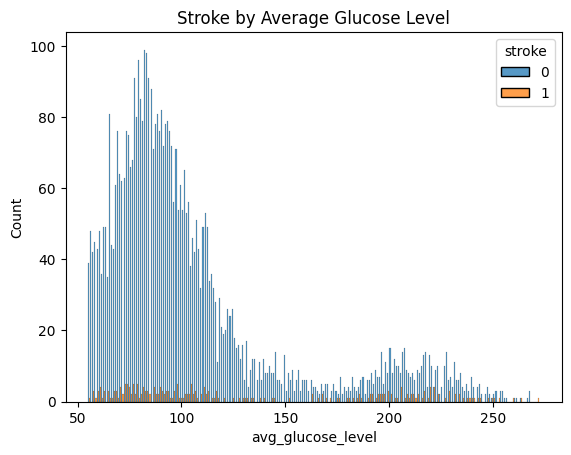

In [28]:
sns.histplot(binwidth=1,
            hue=stroke['stroke'],
            x=stroke['avg_glucose_level'],
            data=stroke,
            stat="count",
            multiple="dodge").set(title='Stroke by Average Glucose Level');

This graph shows that your glucose level doesn't seem to have as much as a corelation to stroke as one might think. People of all glucose levels had strokes based on this graph.

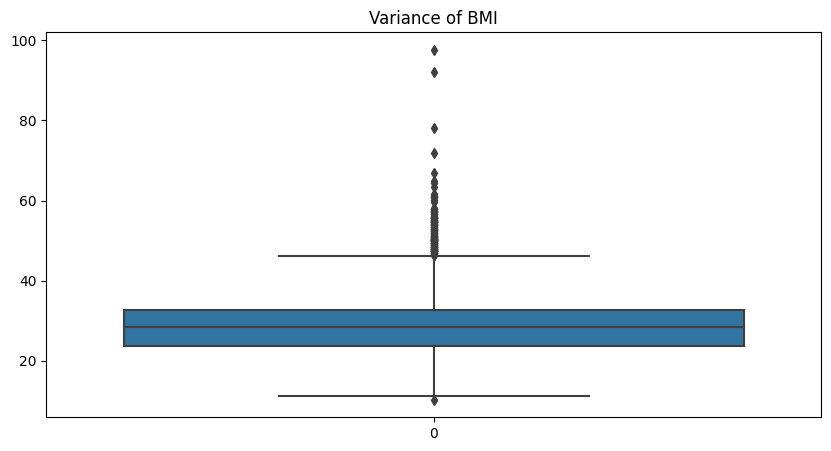

In [29]:
plt.figure(figsize=(10,5))
sns.boxplot(stroke['bmi'])
plt.title("Variance of BMI");

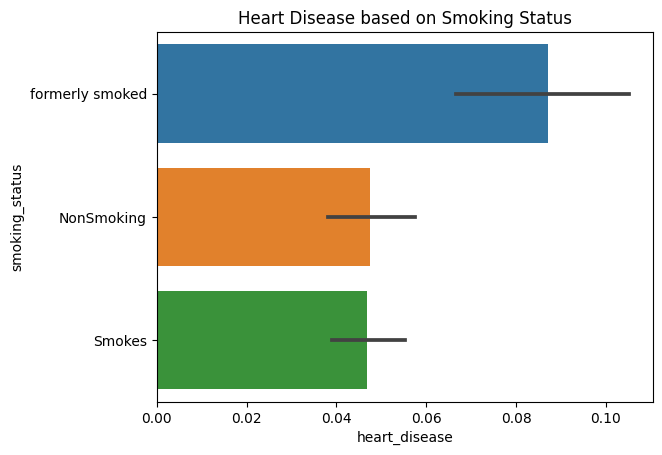

In [30]:
sns.barplot(data=stroke, y='smoking_status', x='heart_disease').set(title='Heart Disease based on Smoking Status');

Finally, this graph shows us the dangers of smoking. Formerly smoked or smokes have a much higher risk of heart disease.

In [31]:
#Get correlations
corr = stroke.corr(numeric_only = True)
corr.round(2)

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
age,1.00,0.28,0.26,0.24,0.33,0.25
hypertension,0.28,1.00,0.11,0.17,0.16,0.13
heart_disease,0.26,0.11,1.00,0.16,0.04,0.13
avg_glucose_level,0.24,0.17,0.16,1.00,0.17,0.13
bmi,0.33,0.16,0.04,0.17,1.00,0.04
stroke,0.25,0.13,0.13,0.13,0.04,1.00


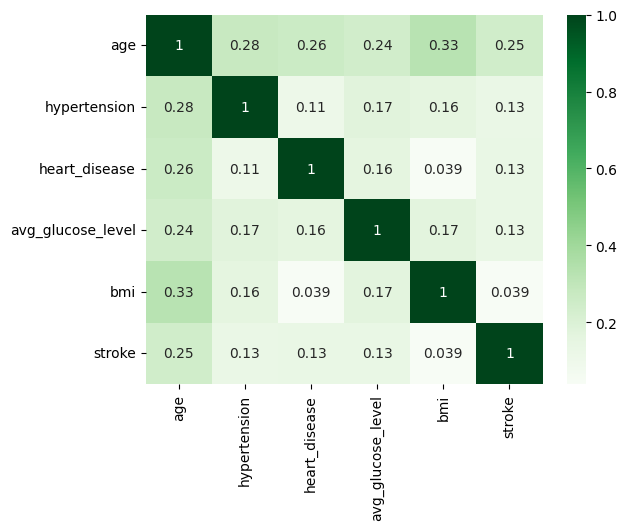

In [32]:
# Make a heatmap of correlations
sns.heatmap(corr, cmap = 'Greens', annot=True);

##No strong correlations within this data set. Best correlation with the target is age. The best for age is BMI. So secondarily you could say their is a correlation to stroke with BMI. BMI and age have the highest correlation, which is not even moderate.

In [33]:
#Checking how many categories in each categorical column
stroke.select_dtypes('object').nunique()

gender            2
work_type         3
Residence_type    2
smoking_status    3
dtype: int64

In [34]:
stroke['work_type'].unique()

array(['Job', 'Self', 'No Job'], dtype=object)

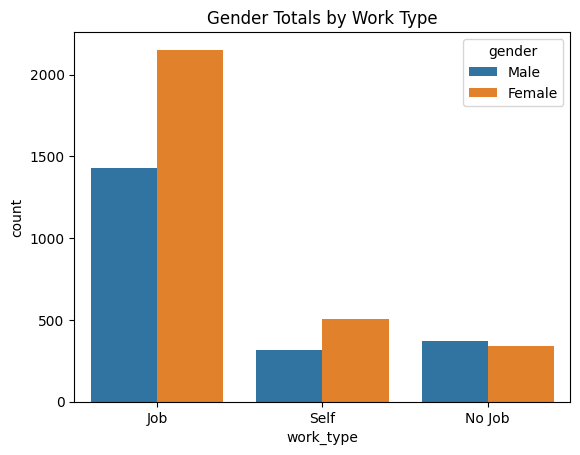

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns',100)

# Multivariate countplot with a hue argument
ax = sns.countplot(data=stroke, x='work_type', hue='gender').set(title='Gender Totals by Work Type')

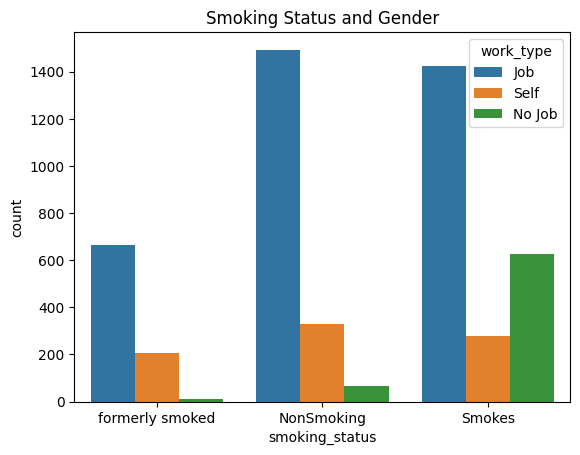

In [36]:
#Multivariate countplot with a hue argument
ax = sns.countplot(data=stroke, x='smoking_status', hue='work_type').set(title='Smoking Status and Gender')

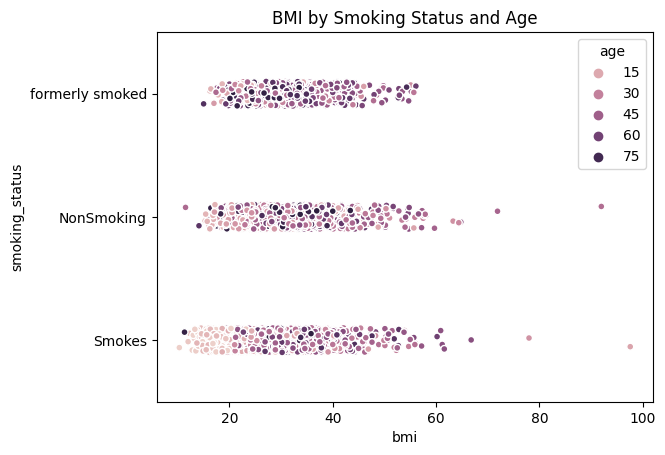

In [37]:
#Customizing a Stipplot
ax = sns.stripplot(data=stroke, x='bmi', y='smoking_status',
                   hue='age', edgecolor='white', linewidth=1).set(title='BMI by Smoking Status and Age')

##What I would present to the stakeholders of the hospital would be fairly simple. I would show them the correlation of Smoking status, Age and Stroke risk. I think any lay person would be able to see what this shows. I did not include BMI because it closely mimics the age catagory.
See my graph below.

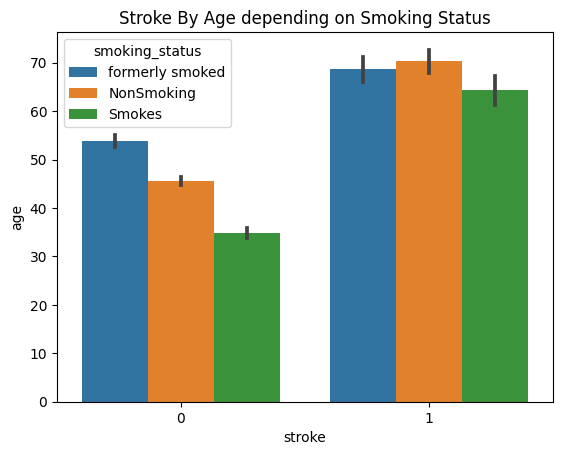

In [38]:
sns.barplot(data=stroke, y='age', x='stroke', hue = 'smoking_status').set(title='Stroke By Age depending on Smoking Status');

#Model Fitting

In [39]:
# Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Classification Metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, \
f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, \
RocCurveDisplay

from sklearn.model_selection import GridSearchCV

# Import SMOTE
# Import special pipeline for smote
from imblearn.pipeline import make_pipeline as smote_pipe

from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')
# Set global scikit-learn configuration 
from sklearn import set_config
# Display estimators as a diagram
set_config(display='diagram') # 'text' or 'diagram'}

# Display all columns
pd.set_option('display.max_column', None)

In [40]:
## Define a function that takes in arguments and prints out a classification report and confusion matrix
def evaluate_classification(model, X_train, y_train, X_test, y_test,
                            cmap='Greens', normalize=None, classes=None, 
                            figsize=(20,5), name='Classification Model', 
                            average='binary', zero_division=0):
  """Takes as required arguments: a model, traing features, training labels,
  testing feature, testing labels
  Prints a classification reports and confusion matrics for each data set
  returns a dataframe of metrics

  Optional arguments: 
    cmap: colormap 
    normalize: confusion matrix normalization ['true', 'pred', 'all' or None]
    classes: ordered list of class labels
    figsize: size of figure
    name: give your model a name
    average: how to aggregate scores for multiclass problems
    zero_division: what should the result of divide by zero be?"""

  # Gather model predictions
  train_preds = model.predict(X_train)
  test_preds = model.predict(X_test)

  # Display classification report and confusion matrices
  print('Train Set Metrics')
  print(metrics.classification_report(y_train, train_preds, 
                                      zero_division=0,
                                      target_names=classes))
  
  print('Test Set Metrics')
  print(metrics.classification_report(y_test, test_preds, 
                                      zero_division=0,
                                      target_names=classes))

  fig, axes = plt.subplots(ncols=2, figsize=figsize)

  ConfusionMatrixDisplay.from_predictions(y_train, train_preds, cmap=cmap, 
                                display_labels=classes,
                                normalize=normalize, ax=axes[0])
  axes[0].set_title('Train Confusion Matrix')

  ConfusionMatrixDisplay.from_predictions(y_test, test_preds, cmap=cmap, 
                              display_labels=classes,
                              normalize=normalize, ax=axes[1])
  axes[1].set_title('Test Confusion Matrix')
  plt.show()

  # If there are more than 2 classes and an average has not been set, 
  # set average to 'macro'
  if average == 'binary' and y_train.nunique() > 2:
    average = 'macro'

  # Create a dataframe of scores to return
  scores = pd.DataFrame()
  
  # Training

  scores.loc[name, 'Train Accuracy'] = accuracy_score(y_train, train_preds)
  scores.loc[name, 'Train Recall'] = recall_score(y_train, train_preds,
                                                           average=average,
                                                       zero_division=zero_division)
  scores.loc[name, 'Train Precision'] = precision_score(y_train, train_preds,
                                                           average=average,
                                                      zero_division=zero_division)
  scores.loc[name, 'Train F1-Score'] = f1_score(y_train, train_preds,
                                                           average=average,
                                                     zero_division=zero_division)
  
  # Testing
  scores.loc[name, 'Test Accuracy'] = accuracy_score(y_test, test_preds)
  scores.loc[name, 'Test Recall'] = recall_score(y_test, test_preds,
                                                           average=average,
                                                      zero_division=zero_division)
  scores.loc[name, 'Test Precision'] = precision_score(y_test, test_preds,
                                                           average=average,
                                                      zero_division=zero_division)
  scores.loc[name, 'Test F1-Score'] = f1_score(y_test, test_preds,
                                                           average=average,
                                                     zero_division=zero_division)

  return scores

In [41]:
# Create a copy of the dataset for Modeling
df = stroke.copy()

In [42]:
# Check how many samples of each class are present
df['stroke'].value_counts()

0    4860
1     249
Name: stroke, dtype: int64

In [43]:
#Convert Gender to numeric
df['gender'] = df['gender'].replace({'Female': 0, 'Male': 1})

In [44]:
# Define features (X) and target (y)
target = 'stroke'
X = df.drop(columns = ['stroke']).copy()
y = df[target].copy()

In [45]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [46]:
# Check how many samples of each class are present for train
y_train.value_counts(normalize=True)

0    0.951188
1    0.048812
Name: stroke, dtype: float64

In [47]:
## Check how many samples of each class are present for test
y_test.value_counts(normalize=True)

0    0.951487
1    0.048513
Name: stroke, dtype: float64

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5109 entries, 0 to 5109
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5109 non-null   int64  
 1   age                5109 non-null   float64
 2   hypertension       5109 non-null   int64  
 3   heart_disease      5109 non-null   int64  
 4   work_type          5109 non-null   object 
 5   Residence_type     5109 non-null   object 
 6   avg_glucose_level  5109 non-null   float64
 7   bmi                5109 non-null   float64
 8   smoking_status     5109 non-null   object 
 9   stroke             5109 non-null   int64  
dtypes: float64(3), int64(4), object(3)
memory usage: 568.1+ KB


#Preprocessing for Machine Learning

In [49]:
# Create preprocessor to scale and one-hot encode the data
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
scaler = StandardScaler()
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')
cat_tuple = (ohe, cat_selector)
num_tuple = (scaler, num_selector)
processor = make_column_transformer(cat_tuple, num_tuple, remainder='drop')

              precision    recall  f1-score   support

           0       0.95      1.00      0.98      1216
           1       0.67      0.03      0.06        62

    accuracy                           0.95      1278
   macro avg       0.81      0.52      0.52      1278
weighted avg       0.94      0.95      0.93      1278



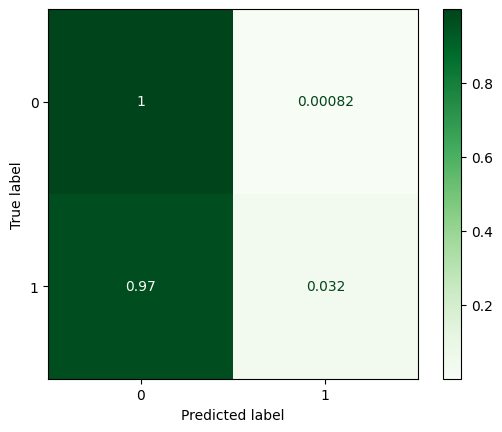

In [50]:
#Create a baseline model pipeline
log_reg = LogisticRegression(max_iter=1000)
scaler = StandardScaler()
log_reg_pipe = make_pipeline(ohe, log_reg)
#Fit and evaluate the baseline model pipeline
log_reg_pipe.fit(X_train, y_train)
test_preds = log_reg_pipe.predict(X_test)
print(classification_report(y_test, test_preds))
ConfusionMatrixDisplay.from_predictions(y_test, test_preds, normalize='true', cmap='Greens');

In [51]:
# Create a model pipeline with the preprocessor and a KNN model
log_reg = LogisticRegression()
log_pipe = make_pipeline(processor, log_reg)
log_pipe.fit(X_train, y_train)
test_preds = log_pipe.predict(X_test)
test_preds[:5]

array([0, 0, 0, 0, 0])

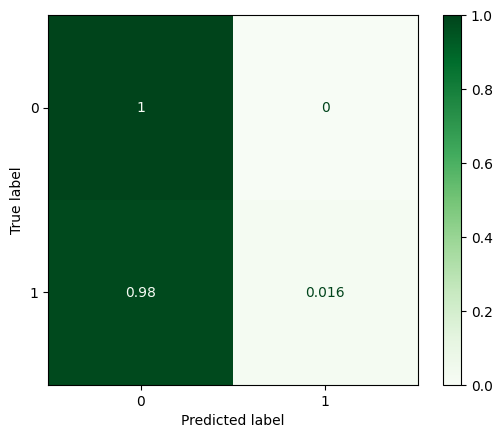

In [52]:
ConfusionMatrixDisplay.from_predictions(y_test, test_preds, normalize='true', cmap='Greens');

In [53]:
# Get the model probability predictions for the test set
test_probs = log_pipe.predict_proba(X_test)
test_probs[:5]

array([[0.94664129, 0.05335871],
       [0.98683473, 0.01316527],
       [0.94154088, 0.05845912],
       [0.9509038 , 0.0490962 ],
       [0.99854866, 0.00145134]])

In [54]:
def convert_probs_to_preds(probabilities, threshold, pos_class=1):
  """Converts float value probabilities into int value predictions.
  If the probability of class 1 is greater than the threshold, the prediction is 1
  Otherwise the prediction is 0
  pos_class determines the index of the positive class in the array of probabilies"""
  predictions = [1 if prob[pos_class] > threshold else 0 for prob in probabilities]
  return predictions


In [55]:
# Convert the model's probability predictions to class predictions
# With a decision threshold of .2
test_preds = convert_probs_to_preds(test_probs, .2)
test_preds[:5]

[0, 0, 0, 0, 0]

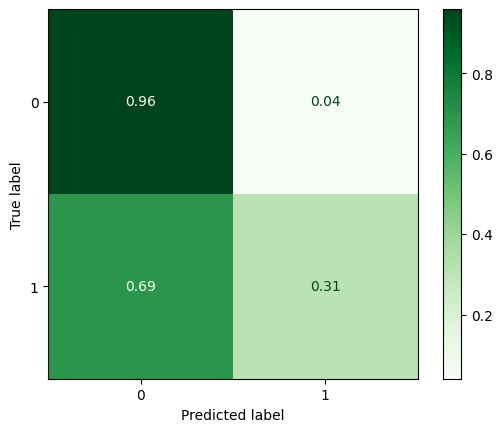

In [56]:
ConfusionMatrixDisplay.from_predictions(y_test, test_preds, normalize='true', cmap='Greens');

In [57]:
# Create an array of float values between 0 and 1 with a step size of .05
thresholds = np.arange(start=0, stop=1.05, step=.05)
# Create empty recall and precision lists
recalls = []
precisions = []
accuracies = []
# Iterate over thresholds
for thresh in thresholds:
  # Convert probabilities to predictions according to each threshold
  preds = convert_probs_to_preds(test_probs, thresh)
  # Record the recall and precision for predictions at that threshold
  recalls.append(recall_score(y_test, preds))
  precisions.append(precision_score(y_test, preds))
  accuracies.append(accuracy_score(y_test, preds))


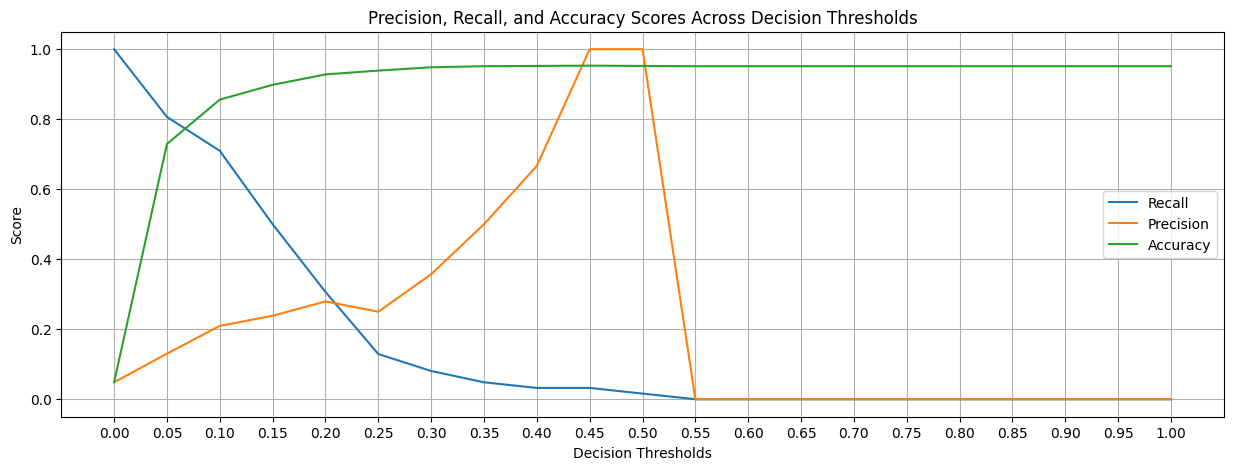

In [58]:
# Plot precisions and recalls for each probability
plt.figure(figsize=(15,5))
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, accuracies, label='Accuracy')
plt.legend()
plt.title('Precision, Recall, and Accuracy Scores Across Decision Thresholds')
plt.xlabel('Decision Thresholds')
plt.ylabel('Score')
plt.grid()
plt.xticks(thresholds)
plt.show();

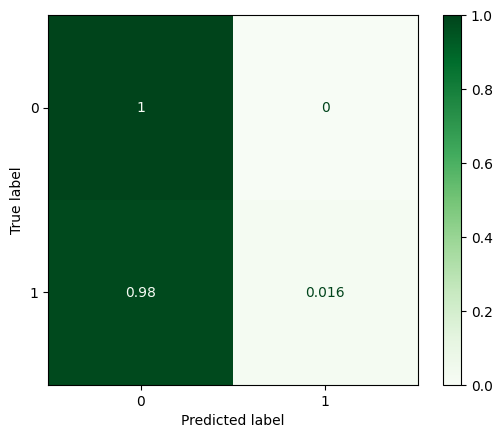

              precision    recall  f1-score   support

           0       0.95      1.00      0.98      1216
           1       1.00      0.02      0.03        62

    accuracy                           0.95      1278
   macro avg       0.98      0.51      0.50      1278
weighted avg       0.95      0.95      0.93      1278



In [59]:
# Convert probabilites to class labels with a decision threshold of 0.5
test_preds = convert_probs_to_preds(test_probs, .5)
# Display a confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, test_preds, normalize='true',
                                        cmap='Greens')
plt.show()
# Print a classification report
print(classification_report(y_test, test_preds));

In [60]:
#import imblearn pipeline
from imblearn.pipeline import make_pipeline as make_sampler_pipeline
from imblearn.under_sampling import RandomUnderSampler
#create scaler and under sampler pipeline
under_sampler = RandomUnderSampler()
scaler = StandardScaler()
under_sample_pipe = make_sampler_pipeline(ohe, under_sampler)
#Compare the shape and value counts of the remaining data.
X_train_under, y_train_under = under_sample_pipe.fit_resample(X_train, y_train)
print('Original X_train class balance')
print(y_train.value_counts())
print('\nUndersampled X_train_under class balance')
y_train_under = pd.Series(y_train_under)
print(y_train_under.value_counts())

Original X_train class balance
0    3644
1     187
Name: stroke, dtype: int64

Undersampled X_train_under class balance
0    187
1    187
Name: stroke, dtype: int64


              precision    recall  f1-score   support

           0       0.98      0.74      0.85      1216
           1       0.13      0.74      0.22        62

    accuracy                           0.74      1278
   macro avg       0.56      0.74      0.53      1278
weighted avg       0.94      0.74      0.82      1278



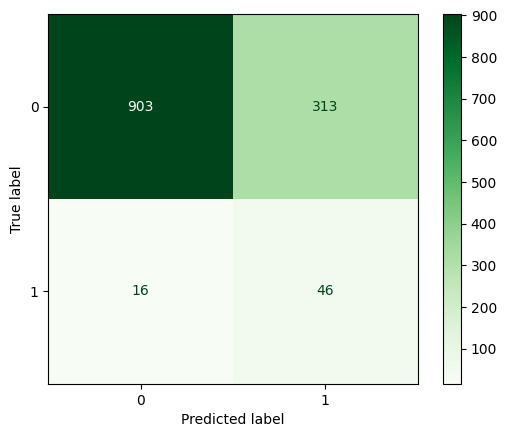

In [61]:
#create the pipeline
log_reg_under = LogisticRegression(max_iter=1000)
under_sample_log_reg_pipe = make_sampler_pipeline(ohe, under_sampler, log_reg_under)
#Fit and evaluate the model
under_sample_log_reg_pipe.fit(X_train, y_train)
test_preds = under_sample_log_reg_pipe.predict(X_test)
print(classification_report(y_test, test_preds))
ConfusionMatrixDisplay.from_predictions(y_test, test_preds, cmap='Greens');

In [62]:
#Import RandomOverSampling
from imblearn.over_sampling import RandomOverSampler
#Create an oversampling pipeline
over_sampler = RandomOverSampler()
over_sample_pipe = make_sampler_pipeline(ohe, over_sampler)
#Scale and oversample the data.
X_train_over, y_train_over = over_sample_pipe.fit_resample(X_train, y_train)
#Explore the sresampled data
print('Original X_train class balance')
print(y_train.value_counts())
print('\nOversampled X_train_over class balance')
y_train_over = pd.Series(y_train_over)
print(y_train_over.value_counts())

Original X_train class balance
0    3644
1     187
Name: stroke, dtype: int64

Oversampled X_train_over class balance
0    3644
1    3644
Name: stroke, dtype: int64


              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1216
           1       0.21      0.31      0.25        62

    accuracy                           0.91      1278
   macro avg       0.59      0.62      0.60      1278
weighted avg       0.93      0.91      0.92      1278



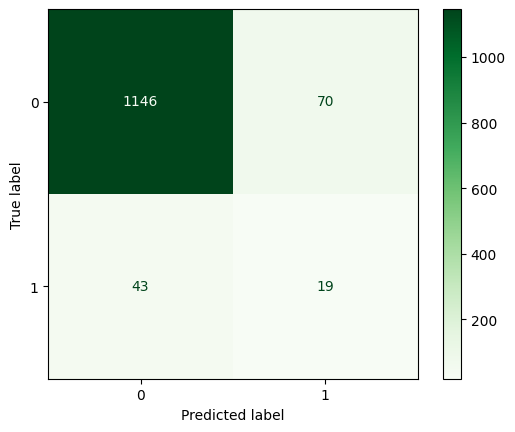

In [63]:
#Create the oversampling modeling pipeline
log_reg_over = LogisticRegression(max_iter=1000)
over_sample_log_reg_pipe = make_sampler_pipeline(ohe, over_sampler, log_reg_over)
#Fit and evaluate the model
over_sample_log_reg_pipe.fit(X_train, y_train)
test_preds = over_sample_log_reg_pipe.predict(X_test)
print(classification_report(y_test, test_preds))
ConfusionMatrixDisplay.from_predictions(y_test, test_preds, cmap='Greens');

              precision    recall  f1-score   support

           0       0.96      0.95      0.95      1216
           1       0.21      0.29      0.25        62

    accuracy                           0.91      1278
   macro avg       0.59      0.62      0.60      1278
weighted avg       0.93      0.91      0.92      1278



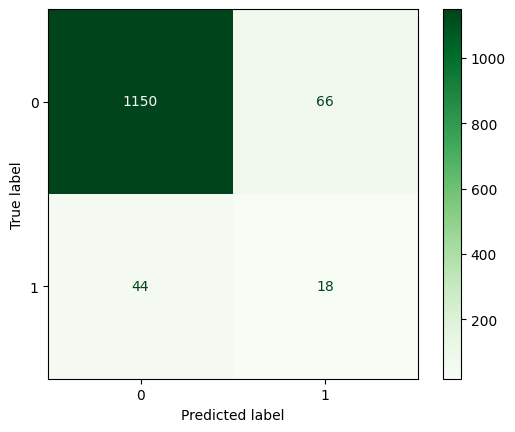

In [64]:
#Create model pipeline with scaler, SMOTE, and model
from imblearn.over_sampling import SMOTE
smote = SMOTE()
log_reg_smote = LogisticRegression(max_iter=1000)
log_reg_smote_pipe = make_sampler_pipeline(ohe, smote, log_reg_smote)
#Fit and evaluate the model pipeline
log_reg_smote_pipe.fit(X_train, y_train)
test_preds = log_reg_smote_pipe.predict(X_test)
print(classification_report(y_test, test_preds))
ConfusionMatrixDisplay.from_predictions(y_test, test_preds,cmap='Greens');

#Logistic Regression

In [65]:
## Create an instance of the model
## Default class_weight=None
log_reg = LogisticRegression(max_iter=1000, class_weight=None)
## Create a model pipeline
log_reg_pipe = make_pipeline(processor, log_reg)
## Fit the model
log_reg_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False,
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f90ab826ad0>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f90aafcc3d0>)])),
                ('logisticregression', LogisticRegression(max_iter=1000))])

Train Set Metrics
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      3644
           1       0.00      0.00      0.00       187

    accuracy                           0.95      3831
   macro avg       0.48      0.50      0.49      3831
weighted avg       0.90      0.95      0.93      3831

Test Set Metrics
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      1216
           1       1.00      0.02      0.03        62

    accuracy                           0.95      1278
   macro avg       0.98      0.51      0.50      1278
weighted avg       0.95      0.95      0.93      1278



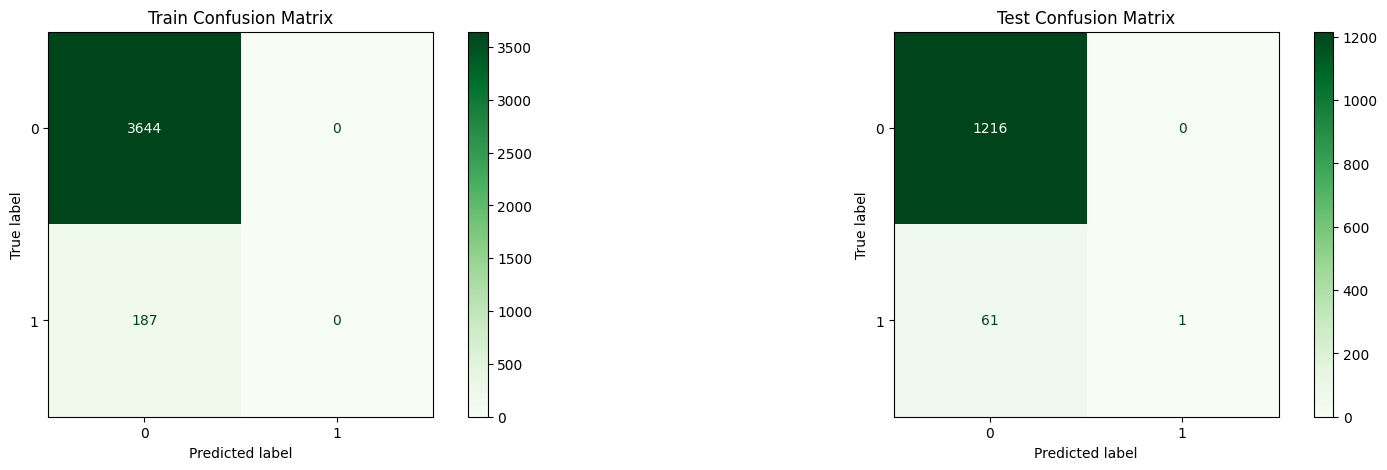

,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Test Accuracy,Test Recall,Test Precision,Test F1-Score
log_reg,0.951188,0.0,0.0,0.0,0.952269,0.016129,1.0,0.031746


In [66]:
## Display the Model's metrics
score = evaluate_classification(log_reg_pipe, X_train, y_train, X_test, y_test, name='log_reg')

score

###Good test accuracy and precision. No False Positives. Too many False Negatives.

In [67]:
# view parameters for pipe
log_reg_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('onehotencoder',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse=False,
                                                  sparse_output=False),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f90ab826ad0>),
                                   ('standardscaler', StandardScaler(),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f90aafcc3d0>)])),
  ('logisticregression', LogisticRegression(max_iter=1000))],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('onehotencoder',
                                  OneHotEncoder(handle_unknown='ignore',
                                                sparse=False,
                                                sparse_output=False),
         

In [68]:
# Make Logistic Regression Pipeline
# Made: log_reg_pipe

#create and visualize our parameter grid
log_reg_param_grid = {'logisticregression__penalty': ['l1','l2'],
              'logisticregression__C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10, 100, 1000, 10000],
              'logisticregression__solver': ['liblinear']}

log_reg_pipe_gs = GridSearchCV(log_reg_pipe, log_reg_param_grid)

log_reg_pipe_gs.fit(X_train, y_train)
print('Best Logistic Regression Parameters:')
print(log_reg_pipe_gs.best_params_)
best_pipe = log_reg_pipe_gs.best_estimator_
print(f'Accuracy of best Logistic Regression model is: {best_pipe.score(X_test, y_test)}')

Best Logistic Regression Parameters:
{'logisticregression__C': 0.0001, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}
Accuracy of best Logistic Regression model is: 0.9514866979655712


In [69]:
## Create an instance of the optimized model using tuned parameters
log_reg_tuned = LogisticRegression(C=0.0001, penalty='l1', solver='liblinear', max_iter=1000, class_weight=None)
## Create a model pipeline
log_reg_tuned_pipe = make_pipeline(processor, log_reg_tuned)
## Fit the model
log_reg_tuned_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False,
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f90ab826ad0>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f90aafcc3d0>)])),
                ('logisticregression',
                 LogisticRegression(C=0.0001, max_iter=1000, penalty='l1',
                                    solver='liblinear'))])

Train Set Metrics
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      3644
           1       0.00      0.00      0.00       187

    accuracy                           0.95      3831
   macro avg       0.48      0.50      0.49      3831
weighted avg       0.90      0.95      0.93      3831

Test Set Metrics
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      1216
           1       0.00      0.00      0.00        62

    accuracy                           0.95      1278
   macro avg       0.48      0.50      0.49      1278
weighted avg       0.91      0.95      0.93      1278



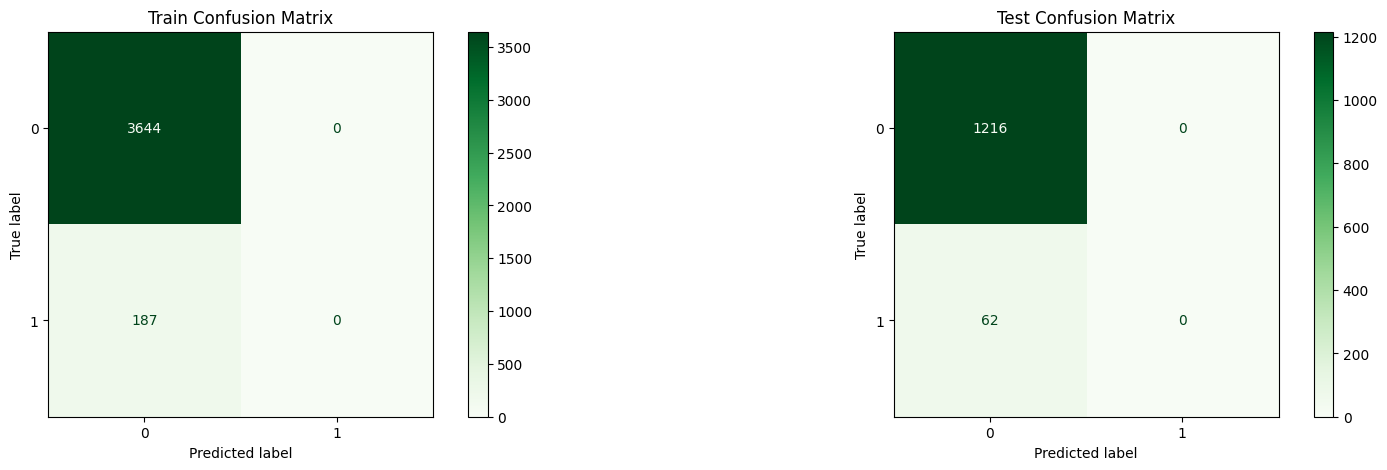

,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Test Accuracy,Test Recall,Test Precision,Test F1-Score
log_reg,0.951188,0.0,0.0,0.0,0.952269,0.016129,1.0,0.031746
log_reg_tuned,0.951188,0.0,0.0,0.0,0.951487,0.000000,0.0,0.000000


In [70]:
## Display the Model's metrics
log_reg_tuned_score = evaluate_classification(log_reg_tuned_pipe, X_train, y_train, X_test, y_test, name='log_reg_tuned')

score = pd.concat([score, log_reg_tuned_score])
score

###Good Test Accuracy. Poor model in every other catagory.

In [71]:
## Create an instance of the optimized model using tuned parameters and SMOTE
log_reg_tuned = LogisticRegression(C=0.0001, penalty='l1', solver='liblinear', max_iter=1000, class_weight=None)
## Create a model pipeline
log_reg_tuned_pipe_smote = make_sampler_pipeline(processor, smote, log_reg_tuned)
## Fit the model
log_reg_tuned_pipe_smote.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False,
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f90ab826ad0>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f90aafcc3d0>)])),
                ('smote', SMOTE()),
                ('logisticregression',
                 LogisticRegression(C=0.0001, max_iter=1000, penalty='l1',
                                    solver='liblinear'))])

Train Set Metrics
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      3644
           1       0.00      0.00      0.00       187

    accuracy                           0.95      3831
   macro avg       0.48      0.50      0.49      3831
weighted avg       0.90      0.95      0.93      3831

Test Set Metrics
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      1216
           1       0.00      0.00      0.00        62

    accuracy                           0.95      1278
   macro avg       0.48      0.50      0.49      1278
weighted avg       0.91      0.95      0.93      1278



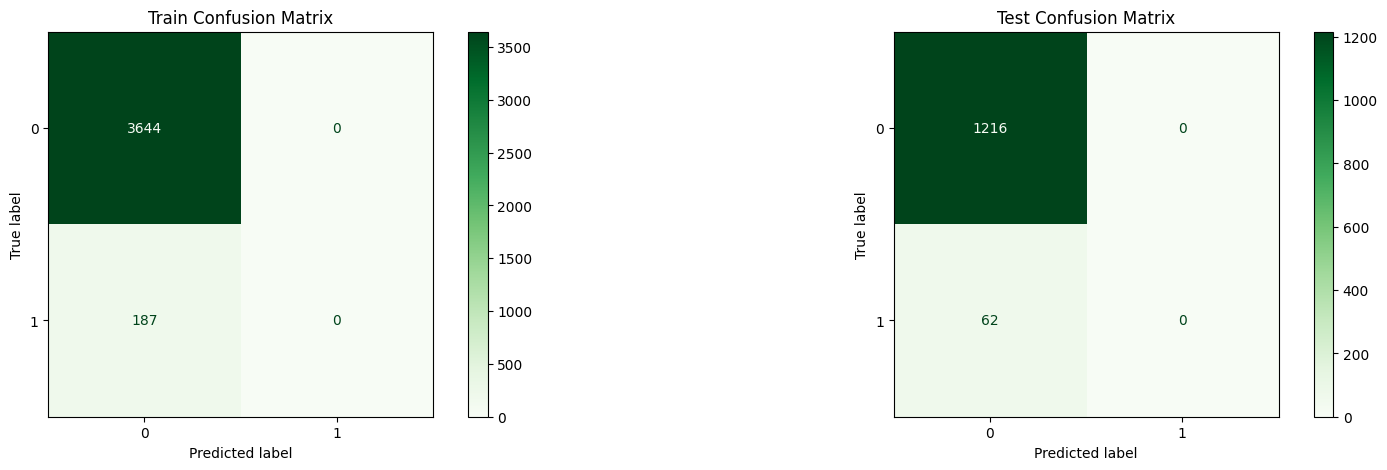

,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Test Accuracy,Test Recall,Test Precision,Test F1-Score
log_reg,0.951188,0.0,0.0,0.0,0.952269,0.016129,1.0,0.031746
log_reg_tuned,0.951188,0.0,0.0,0.0,0.951487,0.000000,0.0,0.000000
log_reg_tuned_smote,0.951188,0.0,0.0,0.0,0.951487,0.000000,0.0,0.000000


In [72]:
## Display the Model's metrics
log_reg_tuned_smote_score = evaluate_classification(log_reg_tuned_pipe_smote, X_train, y_train, X_test, y_test, name='log_reg_tuned_smote')

score = pd.concat([score, log_reg_tuned_smote_score])
score

###Good accuracy. Too many False Negatives. Poor in every other metric.

In [73]:
## Create an instance of the model
knn = KNeighborsClassifier()
## Create a model pipeline
knn_pipe = make_pipeline(processor, knn)
## Fit the model
knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False,
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f90ab826ad0>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f90aafcc3d0>)])),
                ('kneighborsclassifier', KNeighborsClassifier())])

Train Set Metrics
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      3644
           1       0.50      0.05      0.09       187

    accuracy                           0.95      3831
   macro avg       0.73      0.52      0.53      3831
weighted avg       0.93      0.95      0.93      3831

Test Set Metrics
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1216
           1       0.17      0.02      0.03        62

    accuracy                           0.95      1278
   macro avg       0.56      0.51      0.50      1278
weighted avg       0.91      0.95      0.93      1278



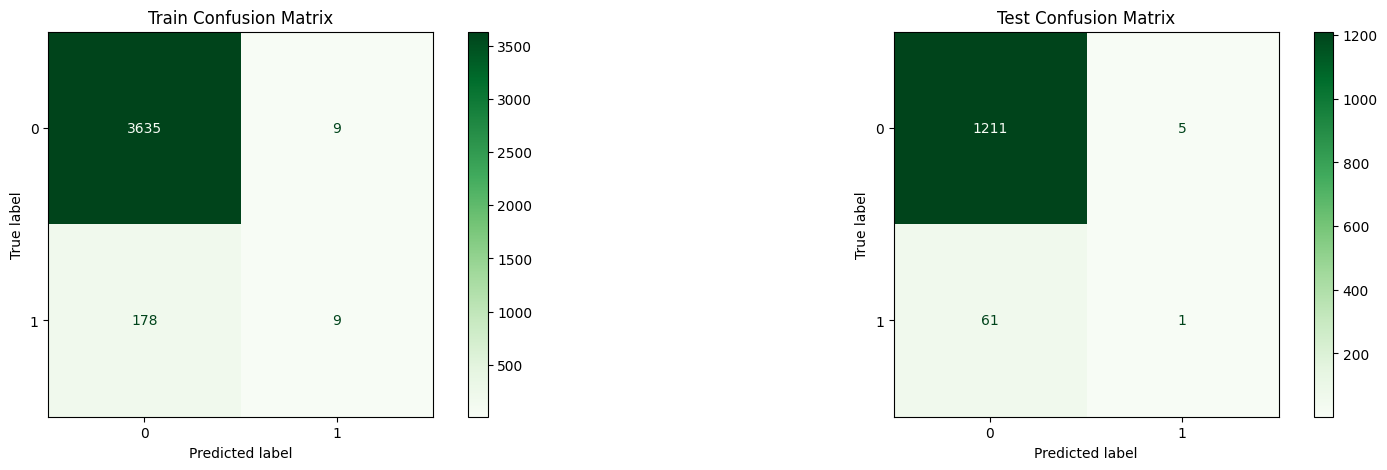

,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Test Accuracy,Test Recall,Test Precision,Test F1-Score
log_reg,0.951188,0.000000,0.0,0.000000,0.952269,0.016129,1.000000,0.031746
log_reg_tuned,0.951188,0.000000,0.0,0.000000,0.951487,0.000000,0.000000,0.000000
log_reg_tuned_smote,0.951188,0.000000,0.0,0.000000,0.951487,0.000000,0.000000,0.000000
knn,0.951188,0.048128,0.5,0.087805,0.948357,0.016129,0.166667,0.029412


In [74]:
## Display the Model's metrics
knn_score = evaluate_classification(knn_pipe, X_train, y_train, X_test, y_test, name='knn')

score = pd.concat([score, knn_score])
score

###Slightly lower accuracy. Added some False positives. One correctly predicted stoke. Recall equal to Logistic Regression. Low Precision and F1 scores.

In [75]:
# view parameters for pipe
knn_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('onehotencoder',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse=False,
                                                  sparse_output=False),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f90ab826ad0>),
                                   ('standardscaler', StandardScaler(),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f90aafcc3d0>)])),
  ('kneighborsclassifier', KNeighborsClassifier())],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('onehotencoder',
                                  OneHotEncoder(handle_unknown='ignore',
                                                sparse=False,
                                                sparse_output=False),
                  

In [76]:
#create and visualize our parameter grid
knn_param_grid = {'kneighborsclassifier__n_neighbors': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],
                  'kneighborsclassifier__p': [1,2,3,4,5]}

knn_pipe_gs = GridSearchCV(knn_pipe, knn_param_grid)

knn_pipe_gs.fit(X_train, y_train)
print('Best Tuned KNN Parameters:')
print(knn_pipe_gs.best_params_)
best_pipe = knn_pipe_gs.best_estimator_
print(f'Accuracy of best tuned KNN model is: {best_pipe.score(X_test, y_test)}')

Best Tuned KNN Parameters:
{'kneighborsclassifier__n_neighbors': 12, 'kneighborsclassifier__p': 2}
Accuracy of best tuned KNN model is: 0.9514866979655712


In [77]:
## Create an instance of the optimized model using tuned parameters
knn_tuned = KNeighborsClassifier(n_neighbors=14, p=4)
## Create a model pipeline
knn_tuned_pipe = make_pipeline(processor, knn_tuned)
## Fit the model
knn_tuned_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False,
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f90ab826ad0>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f90aafcc3d0>)])),
                ('kneighborsclassifier',
                 KNeighborsClassifier(n_neighbors=14, p=4))])

Train Set Metrics
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      3644
           1       0.00      0.00      0.00       187

    accuracy                           0.95      3831
   macro avg       0.48      0.50      0.49      3831
weighted avg       0.90      0.95      0.93      3831

Test Set Metrics
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      1216
           1       0.00      0.00      0.00        62

    accuracy                           0.95      1278
   macro avg       0.48      0.50      0.49      1278
weighted avg       0.91      0.95      0.93      1278



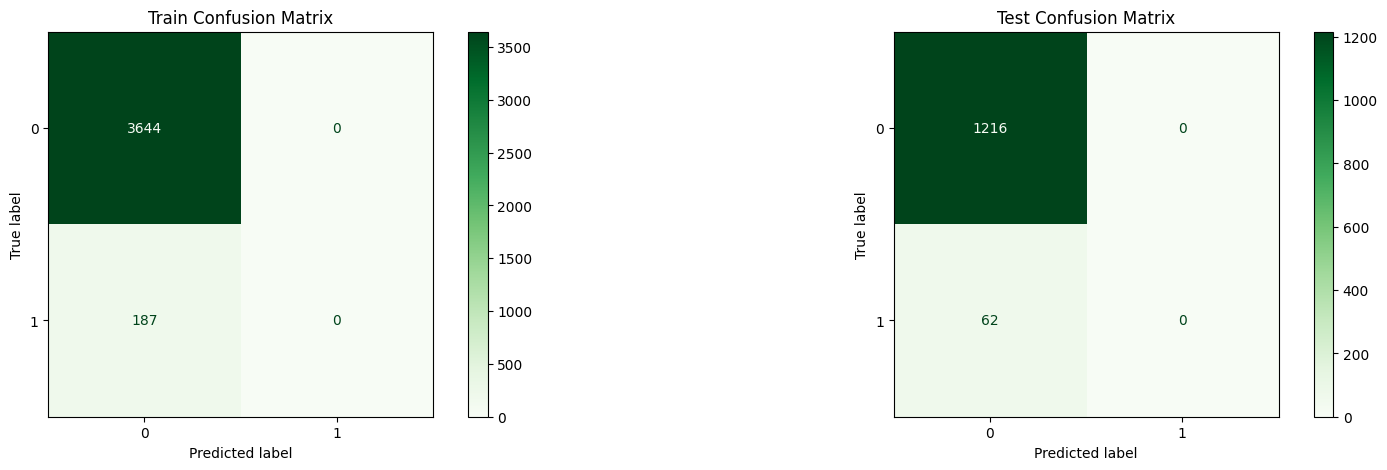

,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Test Accuracy,Test Recall,Test Precision,Test F1-Score
log_reg,0.951188,0.000000,0.0,0.000000,0.952269,0.016129,1.000000,0.031746
log_reg_tuned,0.951188,0.000000,0.0,0.000000,0.951487,0.000000,0.000000,0.000000
log_reg_tuned_smote,0.951188,0.000000,0.0,0.000000,0.951487,0.000000,0.000000,0.000000
knn,0.951188,0.048128,0.5,0.087805,0.948357,0.016129,0.166667,0.029412
knn_tuned,0.951188,0.000000,0.0,0.000000,0.951487,0.000000,0.000000,0.000000


In [78]:
## Display the Model's metrics
knn_tuned_score = evaluate_classification(knn_tuned_pipe, X_train, y_train, X_test, y_test, name='knn_tuned')

score = pd.concat([score, knn_tuned_score])
score

###Good accuracy. Too many False Negatives. Poor showing in other metrics.

In [79]:
## Create an instance of the optimized model using tuned parameters
knn_smote_tuned = KNeighborsClassifier(n_neighbors=14, p=4)
## Create a model pipeline
knn_smote_tuned_pipe = make_sampler_pipeline(processor,smote, knn_smote_tuned)
## Fit the model
knn_smote_tuned_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False,
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f90ab826ad0>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f90aafcc3d0>)])),
                ('smote', SMOTE()),
                ('kneighborsclassifier',
                 KNeighborsClassifier(n_neighbors=14, p=4))])

Train Set Metrics
              precision    recall  f1-score   support

           0       1.00      0.77      0.87      3644
           1       0.18      0.98      0.30       187

    accuracy                           0.78      3831
   macro avg       0.59      0.88      0.58      3831
weighted avg       0.96      0.78      0.84      3831

Test Set Metrics
              precision    recall  f1-score   support

           0       0.98      0.74      0.84      1216
           1       0.11      0.65      0.19        62

    accuracy                           0.73      1278
   macro avg       0.54      0.69      0.51      1278
weighted avg       0.93      0.73      0.81      1278



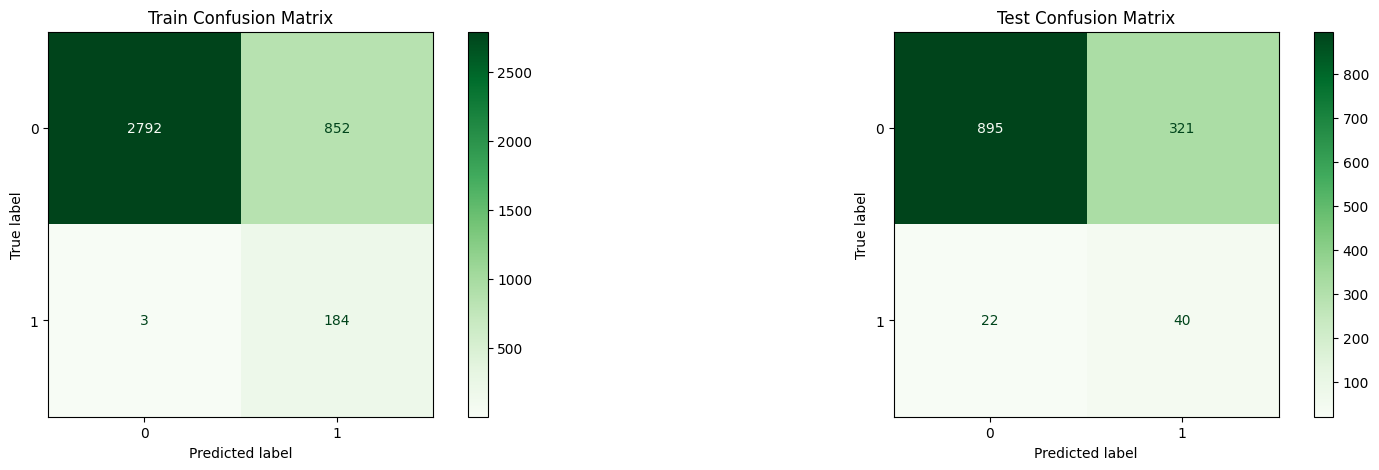

,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Test Accuracy,Test Recall,Test Precision,Test F1-Score
log_reg,0.951188,0.000000,0.000000,0.000000,0.952269,0.016129,1.000000,0.031746
log_reg_tuned,0.951188,0.000000,0.000000,0.000000,0.951487,0.000000,0.000000,0.000000
log_reg_tuned_smote,0.951188,0.000000,0.000000,0.000000,0.951487,0.000000,0.000000,0.000000
knn,0.951188,0.048128,0.500000,0.087805,0.948357,0.016129,0.166667,0.029412
knn_tuned,0.951188,0.000000,0.000000,0.000000,0.951487,0.000000,0.000000,0.000000
knn_reg_tuned_smote,0.776821,0.983957,0.177606,0.300899,0.731612,0.645161,0.110803,0.189125


In [80]:
## Display the Model's metrics
knn_reg_tuned_smote_score = evaluate_classification(knn_smote_tuned_pipe, X_train, y_train, X_test, y_test, name='knn_reg_tuned_smote')

score = pd.concat([score, knn_reg_tuned_smote_score])
score

###Accuracy is ok. Lowered the False Negatives, but False Positives skyrocketed. Correctly predicted many more strokes, but fewer non strokes.

#KNN with PCA

In [81]:
from sklearn.decomposition import PCA

In [82]:
scaled_df_pca = scaler.fit_transform(X_train_under, y_train_under)
pca = PCA(n_components=.95)
pca.fit(scaled_df_pca)

PCA(n_components=0.95)

In [83]:
## Create an instance of the optimized model using tuned parameters
knn_pca_tuned = KNeighborsClassifier(n_neighbors=14, p=4)
## Create a model pipeline
knn_pca_tuned_pipe = make_sampler_pipeline(processor, pca, knn_pca_tuned)
## Fit the model
knn_pca_tuned_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False,
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f90ab826ad0>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f90aafcc3d0>)])),
                ('pca', PCA(n_components=0.95)),
                ('kneighborsclassifier',
                 KNeighborsClassifier(n_neighbors=14, p=4))])

Train Set Metrics
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      3644
           1       0.00      0.00      0.00       187

    accuracy                           0.95      3831
   macro avg       0.48      0.50      0.49      3831
weighted avg       0.90      0.95      0.93      3831

Test Set Metrics
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      1216
           1       0.00      0.00      0.00        62

    accuracy                           0.95      1278
   macro avg       0.48      0.50      0.49      1278
weighted avg       0.91      0.95      0.93      1278



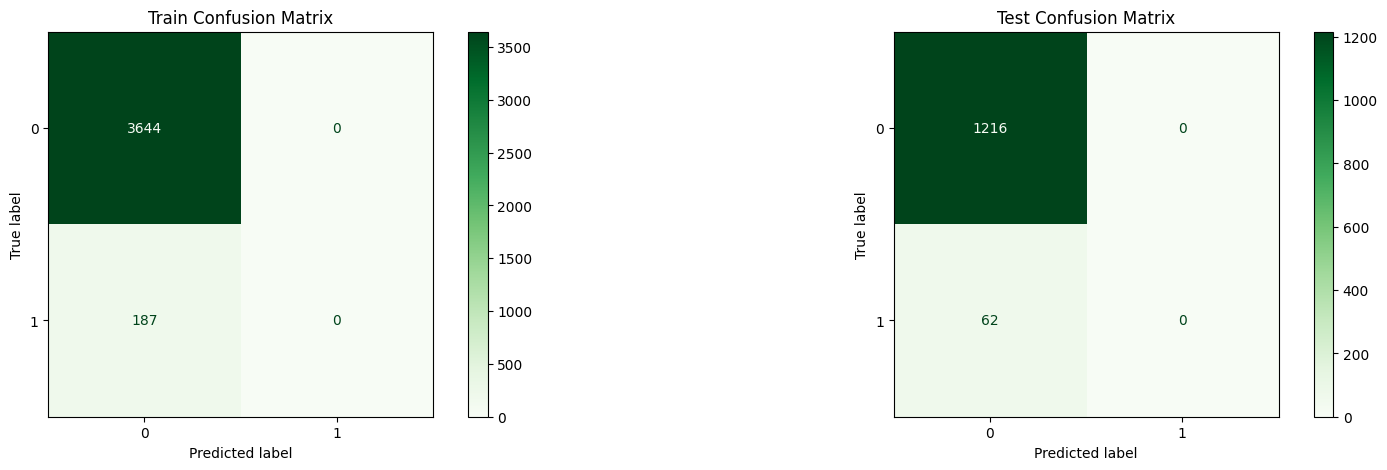

,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Test Accuracy,Test Recall,Test Precision,Test F1-Score
log_reg,0.951188,0.000000,0.000000,0.000000,0.952269,0.016129,1.000000,0.031746
log_reg_tuned,0.951188,0.000000,0.000000,0.000000,0.951487,0.000000,0.000000,0.000000
log_reg_tuned_smote,0.951188,0.000000,0.000000,0.000000,0.951487,0.000000,0.000000,0.000000
knn,0.951188,0.048128,0.500000,0.087805,0.948357,0.016129,0.166667,0.029412
knn_tuned,0.951188,0.000000,0.000000,0.000000,0.951487,0.000000,0.000000,0.000000
knn_reg_tuned_smote,0.776821,0.983957,0.177606,0.300899,0.731612,0.645161,0.110803,0.189125
knn_reg_tuned_pca,0.951188,0.000000,0.000000,0.000000,0.951487,0.000000,0.000000,0.000000


In [84]:
## Display the Model's metrics
knn_reg_tuned_pca_score = evaluate_classification(knn_pca_tuned_pipe, X_train, y_train, X_test, y_test, name='knn_reg_tuned_pca')

score = pd.concat([score, knn_reg_tuned_pca_score])
score

###Good accuracy. Too many False Negatives.

#Random Forest

In [85]:
## Create an instance of the model
rfc = RandomForestClassifier()
## Create a model pipeline
rfc_pipe = make_pipeline(processor, rfc)
## Fit the model
rfc_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False,
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f90ab826ad0>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f90aafcc3d0>)])),
                ('randomforestclassifier', RandomForestClassifier())])

Train Set Metrics
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3644
           1       1.00      1.00      1.00       187

    accuracy                           1.00      3831
   macro avg       1.00      1.00      1.00      3831
weighted avg       1.00      1.00      1.00      3831

Test Set Metrics
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      1216
           1       0.00      0.00      0.00        62

    accuracy                           0.95      1278
   macro avg       0.48      0.50      0.49      1278
weighted avg       0.91      0.95      0.93      1278



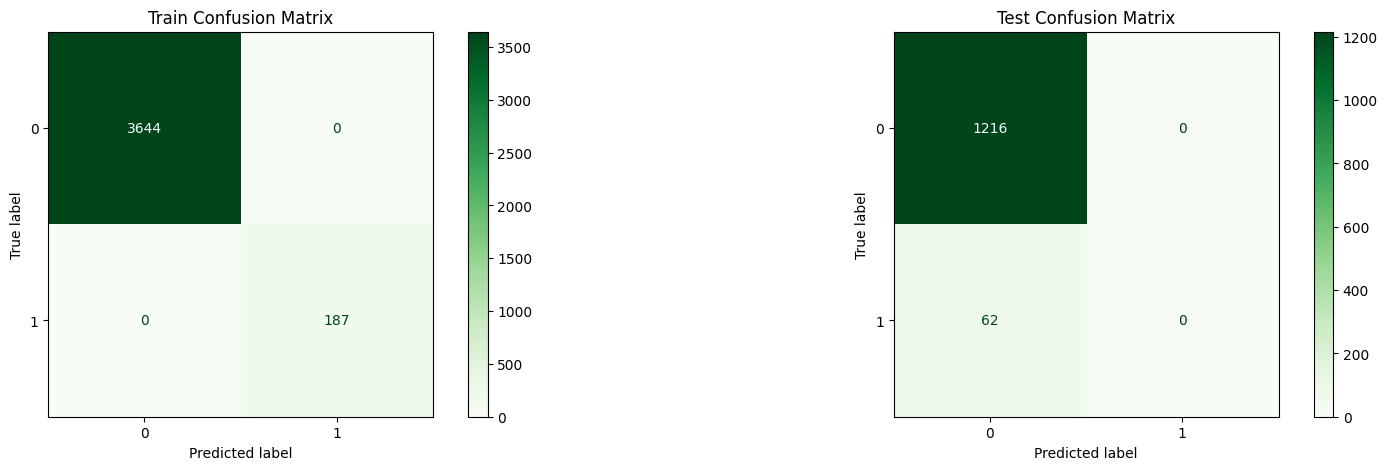

,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Test Accuracy,Test Recall,Test Precision,Test F1-Score
log_reg,0.951188,0.000000,0.000000,0.000000,0.952269,0.016129,1.000000,0.031746
log_reg_tuned,0.951188,0.000000,0.000000,0.000000,0.951487,0.000000,0.000000,0.000000
log_reg_tuned_smote,0.951188,0.000000,0.000000,0.000000,0.951487,0.000000,0.000000,0.000000
knn,0.951188,0.048128,0.500000,0.087805,0.948357,0.016129,0.166667,0.029412
knn_tuned,0.951188,0.000000,0.000000,0.000000,0.951487,0.000000,0.000000,0.000000
knn_reg_tuned_smote,0.776821,0.983957,0.177606,0.300899,0.731612,0.645161,0.110803,0.189125
knn_reg_tuned_pca,0.951188,0.000000,0.000000,0.000000,0.951487,0.000000,0.000000,0.000000
rfc,1.000000,1.000000,1.000000,1.000000,0.951487,0.000000,0.000000,0.000000


In [86]:
## Display the Model's metrics
rfc_score = evaluate_classification(rfc_pipe, X_train, y_train, X_test, y_test, name='rfc')

score = pd.concat([score, rfc_score])
score

###Good accuracy. Other test metrics poor while train is perfect. Interesting.

In [87]:
# Find max_depth for default RandomForestClassifier
max((e.tree_.max_depth for e in rfc.estimators_))

23

In [88]:
# view parameters for pipe
rfc_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('onehotencoder',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse=False,
                                                  sparse_output=False),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f90ab826ad0>),
                                   ('standardscaler', StandardScaler(),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f90aafcc3d0>)])),
  ('randomforestclassifier', RandomForestClassifier())],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('onehotencoder',
                                  OneHotEncoder(handle_unknown='ignore',
                                                sparse=False,
                                                sparse_output=False),
              

In [89]:
#create and visualize our parameter grid
rfc_param_grid = {'randomforestclassifier__max_depth': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],
                  'randomforestclassifier__n_estimators':[25, 50, 75, 150]}

rfc_pipe_gs = GridSearchCV(rfc_pipe, rfc_param_grid)

rfc_pipe_gs.fit(X_train, y_train)
print('Best Tuned Random Forest Parameters:')
print(rfc_pipe_gs.best_params_)
best_pipe = rfc_pipe_gs.best_estimator_
print(f'Accuracy of best tuned Random Forest model is: {best_pipe.score(X_test, y_test)}')

Best Tuned Random Forest Parameters:
{'randomforestclassifier__max_depth': 1, 'randomforestclassifier__n_estimators': 25}
Accuracy of best tuned Random Forest model is: 0.9514866979655712


In [90]:
## Create an instance of the optimized model using tuned parameters
rfc_tuned = RandomForestClassifier(max_depth=1, n_estimators=25)
## Create a model pipeline
rfc_tuned_pipe = make_pipeline(processor, rfc_tuned)
## Fit the model
rfc_tuned_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False,
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f90ab826ad0>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f90aafcc3d0>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=1, n_estimators=25))])

Train Set Metrics
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      3644
           1       0.00      0.00      0.00       187

    accuracy                           0.95      3831
   macro avg       0.48      0.50      0.49      3831
weighted avg       0.90      0.95      0.93      3831

Test Set Metrics
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      1216
           1       0.00      0.00      0.00        62

    accuracy                           0.95      1278
   macro avg       0.48      0.50      0.49      1278
weighted avg       0.91      0.95      0.93      1278



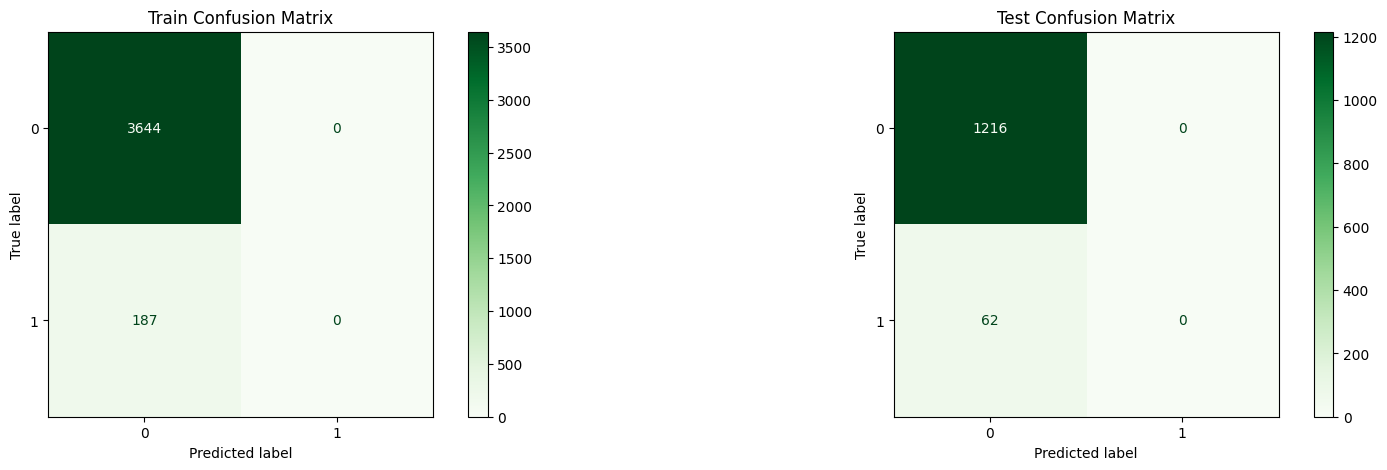

,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Test Accuracy,Test Recall,Test Precision,Test F1-Score
log_reg,0.951188,0.000000,0.000000,0.000000,0.952269,0.016129,1.000000,0.031746
log_reg_tuned,0.951188,0.000000,0.000000,0.000000,0.951487,0.000000,0.000000,0.000000
log_reg_tuned_smote,0.951188,0.000000,0.000000,0.000000,0.951487,0.000000,0.000000,0.000000
knn,0.951188,0.048128,0.500000,0.087805,0.948357,0.016129,0.166667,0.029412
knn_tuned,0.951188,0.000000,0.000000,0.000000,0.951487,0.000000,0.000000,0.000000
knn_reg_tuned_smote,0.776821,0.983957,0.177606,0.300899,0.731612,0.645161,0.110803,0.189125
knn_reg_tuned_pca,0.951188,0.000000,0.000000,0.000000,0.951487,0.000000,0.000000,0.000000
rfc,1.000000,1.000000,1.000000,1.000000,0.951487,0.000000,0.000000,0.000000
rfc_tuned,0.951188,0.000000,0.000000,0.000000,0.951487,0.000000,0.000000,0.000000


In [91]:
## Display the Model's metrics
rfc_tuned_score = evaluate_classification(rfc_tuned_pipe, X_train, y_train, X_test, y_test, name='rfc_tuned')

score = pd.concat([score, rfc_tuned_score])
score

###Good accuracy. Poor other Test and train metrics. Too many False Negatives.

In [92]:
## Create an instance of the optimized model using tuned parameters
rfc_smote_tuned = RandomForestClassifier(max_depth=1, n_estimators=25)
## Create a model pipeline
rfc_tuned_smote_pipe = make_sampler_pipeline(processor, smote, rfc_smote_tuned)
## Fit the model
rfc_tuned_smote_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False,
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f90ab826ad0>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f90aafcc3d0>)])),
                ('smote', SMOTE()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=1, n_estimators=25))])

Train Set Metrics
              precision    recall  f1-score   support

           0       0.99      0.63      0.77      3644
           1       0.11      0.90      0.20       187

    accuracy                           0.64      3831
   macro avg       0.55      0.76      0.48      3831
weighted avg       0.95      0.64      0.74      3831

Test Set Metrics
              precision    recall  f1-score   support

           0       0.99      0.63      0.77      1216
           1       0.10      0.85      0.19        62

    accuracy                           0.64      1278
   macro avg       0.55      0.74      0.48      1278
weighted avg       0.95      0.64      0.74      1278



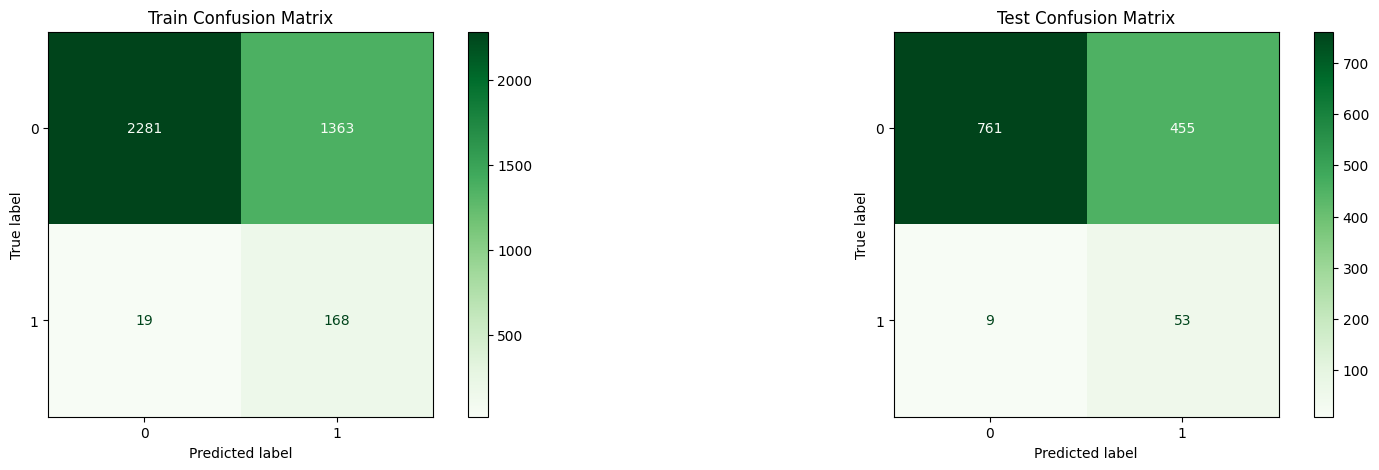

,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Test Accuracy,Test Recall,Test Precision,Test F1-Score
log_reg,0.951188,0.000000,0.000000,0.000000,0.952269,0.016129,1.000000,0.031746
log_reg_tuned,0.951188,0.000000,0.000000,0.000000,0.951487,0.000000,0.000000,0.000000
log_reg_tuned_smote,0.951188,0.000000,0.000000,0.000000,0.951487,0.000000,0.000000,0.000000
knn,0.951188,0.048128,0.500000,0.087805,0.948357,0.016129,0.166667,0.029412
knn_tuned,0.951188,0.000000,0.000000,0.000000,0.951487,0.000000,0.000000,0.000000
knn_reg_tuned_smote,0.776821,0.983957,0.177606,0.300899,0.731612,0.645161,0.110803,0.189125
knn_reg_tuned_pca,0.951188,0.000000,0.000000,0.000000,0.951487,0.000000,0.000000,0.000000
rfc,1.000000,1.000000,1.000000,1.000000,0.951487,0.000000,0.000000,0.000000
rfc_tuned,0.951188,0.000000,0.000000,0.000000,0.951487,0.000000,0.000000,0.000000
rfc_smote_tuned,0.639259,0.898396,0.109732,0.195576,0.636933,0.854839,0.104331,0.185965


In [93]:
## Display the Model's metrics
rfc_tuned_smote_score = evaluate_classification(rfc_tuned_smote_pipe, X_train, y_train, X_test, y_test, name='rfc_smote_tuned')

score = pd.concat([score, rfc_tuned_smote_score])
score

###Lowest False Negatives. High predicted strokes. Many False Negatives with lower predicted best outcome. Accuracy took a hit. But are the False Negatives worth it in the end.

#**Best Model**

#The model I would choose would be Random Forest Tuned with SMOTE. Decent accuracy. Good recall. Second best F1 score. Most importantly low False Negatives and good numnber of predicted strokes. The lower False negatives is worth the False positive increase. These patient's probably have a comorbitity that they probably should address anyway.